# Task 02: 
Stimulate Catastrophic Forgetting of IDS static model when encounter NSL-KDD's concept drift

In [1]:
# Cell 1: Setup & Import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- USER CONFIGURATION START ---
from pathlib import Path
# Data paths
data_dir = Path(r'H:\tdc_window\Workspace\Testspace\ids\exp_data')
train_file = data_dir / 'KDDTrain+.txt'
test_file = data_dir / 'KDDTest+.txt'

# Column names
standard_column_names = [
    # Intrinsic (1-9)
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
    # Content (10-22)
    'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
    # Time-based (23-31)
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    # Host-based (32-41)
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    # Label + Difficulty
    'attack_type', 'difficulty'
]

# Attack categories mapping (Group -> List of Sub-attacks)
attack_categories = {
    'Normal': 'normal', # Chú ý: Key là nhóm lớn
    'DoS': ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'mailbomb', 'apache2', 'processtable', 'udpstorm'],
    'Probe': ['ipsweep', 'nmap', 'portsweep', 'satan', 'mscan', 'saint'],
    'R2L': ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy', 'warezclient', 'warezmaster', 'sendmail', 'named', 'snmpgetattack', 'snmpguess', 'xlock', 'xsnoop', 'worm'],
    'U2R': ['buffer_overflow', 'loadmodule', 'perl', 'rootkit', 'httptunnel', 'ps', 'sqlattack', 'xterm']
}
# --- USER CONFIGURATION END ---

In [2]:
# Cell 2: Data Loading & Preprocessing Function

def load_and_process_data(file_path, cols, mapping_dict, drop_difficulty=False):
    """
    Đọc file NSL-KDD, map attack_type -> label (nhóm), trả về DataFrame sạch.
    mapping_dict: dạng {Nhóm: [danh sách sub-attack]} hoặc {Nhóm: 'single_value'} (vd. Normal: 'normal').
    drop_difficulty: nếu False (mặc định), giữ cột difficulty cho phân tích / thiết kế thí nghiệm.
                      Khi train mô hình chính thức, set True hoặc loại difficulty khỏi danh sách feature.
    """
    # 1. Đọc CSV không có header
    df = pd.read_csv(file_path, names=cols)
    # Chuẩn hóa attack_type: strip và bỏ dấu chấm thừa (đồng bộ với 01)
    df['attack_type'] = df['attack_type'].astype(str).str.strip().str.rstrip('.')

    # 2. Đảo ngược mapping: {sub_attack: Nhóm}
    reversed_mapping = {}
    for group, value in mapping_dict.items():
        if isinstance(value, list):
            for sub in value:
                reversed_mapping[sub] = group
        else:
            # Normal -> 'normal' (single string)
            reversed_mapping[value] = group

    # 3. Tạo cột label từ attack_type
    df['label'] = df['attack_type'].map(reversed_mapping)

    # 4. Xử lý ngoại lệ: attack type lạ -> 'Unknown'
    df['label'] = df['label'].fillna('Unknown')

    # 5. Drop cột difficulty chỉ khi cần (cho pipeline train); mặc định giữ để phân tích
    if drop_difficulty:
        df = df.drop(columns=['difficulty'], errors='ignore')

    # 6. Trả về DataFrame đã sạch
    return df


# Load train và test (giữ difficulty cho phân tích / thí nghiệm; không dùng làm input khi train mô hình)
train_df = load_and_process_data(train_file, standard_column_names, attack_categories)
test_df = load_and_process_data(test_file, standard_column_names, attack_categories)

# Imbalance Check: value_counts của label trên cả 2 tập
print("=== TRAIN - value_counts(label) ===")
print(train_df['label'].value_counts())
print("\n=== TEST - value_counts(label) ===")
print(test_df['label'].value_counts())

=== TRAIN - value_counts(label) ===
label
Normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64

=== TEST - value_counts(label) ===
label
Normal    9711
DoS       7458
R2L       2754
Probe     2421
U2R        200
Name: count, dtype: int64


In [3]:
# Cell 2.5: Data Type Inspection & Validation

# 1. Tổng quan kiểu dữ liệu (Dtype) của toàn bộ các cột
train_df.info()

# 2. Tự động phát hiện các cột dạng chuỗi (object)
object_cols = train_df.select_dtypes(include=['object']).columns.tolist()

# 3. Loại bỏ các cột nhãn — không encode vào features
label_cols = ['label', 'attack_type', 'difficulty']
categorical_cols = [c for c in object_cols if c not in label_cols]

# 4. (Đã lưu vào categorical_cols ở bước 3)

# 5. In danh sách categorical và 5 giá trị duy nhất đầu tiên của từng cột
print("\n=== Categorical feature columns (dùng cho encoding) ===")
print("categorical_cols:", categorical_cols)

print("\n=== 5 giá trị duy nhất đầu tiên theo cột ===")
for col in categorical_cols:
    uniques = train_df[col].dropna().unique()[:5]
    print(f"  {col}: {list(uniques)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 44 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [ ]:
# Cell 3: Feature Engineering - Encoding

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Biến X (features): loại bỏ label, attack_type, difficulty
exclude_cols = ['label', 'attack_type', 'difficulty']
X_train = train_df.drop(columns=exclude_cols)
X_test = test_df.drop(columns=exclude_cols)

# Nhãn (target) từ cột label
y_train = train_df['label']
y_test = test_df['label']

# Xem 3 dòng đầu của X_train và X_test
print("=== X_train (3 dòng đầu) ===")
display(X_train.head(3))
print("\n=== X_test (3 dòng đầu) ===")
display(X_test.head(3))

# ColumnTransformer: OneHotEncoder cho categorical_cols, passthrough cho cột số
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_cols),
    ],
    remainder='passthrough'
)

# Fit trên TRAIN, transform cả TRAIN và TEST
preprocessor.fit(X_train)
X_train_encoded = preprocessor.transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Kiểm tra
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("X_train_encoded.shape:", X_train_encoded.shape)
print("X_test_encoded.shape:", X_test_encoded.shape)

print("\ny_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)
print("y_train (3 record đầu):", y_train.head(3).tolist())
print("y_test (3 record đầu):", y_test.head(3).tolist())


=== X_train (3 dòng đầu) ===


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,150,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0
1,0,udp,other,SF,146,0,0,0,0,0,...,255,1,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0
2,0,tcp,private,S0,0,0,0,0,0,0,...,255,26,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0



=== X_test (3 dòng đầu) ===


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,private,REJ,0,0,0,0,0,0,...,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.0,1.0
1,0,tcp,private,REJ,0,0,0,0,0,0,...,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.0,1.0
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.0,0.0


X_train.shape: (125973, 41)
X_test.shape: (22544, 41)
X_train_encoded.shape: (125973, 122)
X_test_encoded.shape: (22544, 122)

y_train.shape: (125973,)
y_test.shape: (22544,)
y_train (3 record đầu): ['Normal', 'Normal', 'DoS']
y_test (3 record đầu): ['DoS', 'DoS', 'Normal']


In [ ]:
# Cell 4: Phân chia Giai đoạn - Phase Splitting

# Phase 0: Normal, DoS, Probe
mask_phase0 = y_train.isin(['Normal', 'DoS', 'Probe'])
X_phase0 = X_train_encoded[mask_phase0.values]
y_phase0 = y_train[mask_phase0]

# Phase 1: Khái niệm mới - R2L
mask_phase1 = (y_train == 'R2L')
X_phase1 = X_train_encoded[mask_phase1.values]
y_phase1 = y_train[mask_phase1]

# Phase 2: Khái niệm hiếm - U2R
mask_phase2 = (y_train == 'U2R')
X_phase2 = X_train_encoded[mask_phase2.values]
y_phase2 = y_train[mask_phase2]

# Giữ nguyên X_test_encoded, y_test làm chuẩn đánh giá tổng thể (Global Evaluation)
# (đã có sẵn từ Cell 3, không thay đổi)

print("Phase 0 (Normal, DoS, Probe):", X_phase0.shape[0], "mẫu")
print("Phase 1 (only R2L):", X_phase1.shape[0], "mẫu")
print("Phase 2 (only U2R):", X_phase2.shape[0], "mẫu")
print("Global test (X_test_encoded):", X_test_encoded.shape[0], "mẫu")

Phase 0 (Normal, DoS, Probe): 124926 mẫu
Phase 1 (R2L): 995 mẫu
Phase 2 (U2R): 52 mẫu
Global test (X_test_encoded): 22544 mẫu


In [9]:
# Cell 5: Random Forest theo phase & đánh giá Catastrophic Forgetting
# Mục tiêu: Mô phỏng Concept Drift (đưa lớp vào từng phase), đo suy giảm bằng Forgetting measure.

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Đảm bảo đánh giá đủ 5 lớp trên global test (không chỉ accuracy)
TARGET_CLASSES = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']

# Random state để tái lặp thí nghiệm
RANDOM_STATE = 42

# --- Model 1: Chỉ train Phase 0 (baseline cho các lớp cũ) ---
# Mô phỏng: ban đầu IDS chỉ biết Normal, DoS, Probe.
print("=== Model 1: Train chỉ Phase 0 (Normal, DoS, Probe) ===")
print("Train shape:", X_phase0.shape)
rf_phase0 = RandomForestClassifier(random_state=RANDOM_STATE)
rf_phase0.fit(X_phase0, y_phase0.values)
pred_0 = rf_phase0.predict(X_test_encoded)
report_0 = classification_report(y_test, pred_0, labels=TARGET_CLASSES, output_dict=True, zero_division=0)
print(classification_report(y_test, pred_0, labels=TARGET_CLASSES, zero_division=0))

# --- Model 2: Train Phase 0 + Phase 1 (thêm R2L - concept mới) ---
# Kiểm chứng: in shape sau khi ghép.
X_01 = np.vstack((X_phase0, X_phase1))
y_01 = np.concatenate([y_phase0.values, y_phase1.values])
print("\n=== Model 2: Train Phase 0 + Phase 1 (thêm R2L) ===")
print("Train shape:", X_01.shape)
rf_phase01 = RandomForestClassifier(random_state=RANDOM_STATE)
rf_phase01.fit(X_01, y_01)
pred_01 = rf_phase01.predict(X_test_encoded)
report_01 = classification_report(y_test, pred_01, labels=TARGET_CLASSES, output_dict=True, zero_division=0)
print(classification_report(y_test, pred_01, labels=TARGET_CLASSES, zero_division=0))

# --- Model 3: Train Phase 0 + Phase 1 + Phase 2 (đủ 5 lớp) ---
X_012 = np.vstack((X_01, X_phase2))
y_012 = np.concatenate([y_01, y_phase2.values])
print("\n=== Model 3: Train Phase 0 + Phase 1 + Phase 2 (đủ 5 lớp) ===")
print("Train shape:", X_012.shape)
rf_phase012 = RandomForestClassifier(random_state=RANDOM_STATE)
rf_phase012.fit(X_012, y_012)
pred_012 = rf_phase012.predict(X_test_encoded)
report_012 = classification_report(y_test, pred_012, labels=TARGET_CLASSES, output_dict=True, zero_division=0)
print(classification_report(y_test, pred_012, labels=TARGET_CLASSES, zero_division=0))

# --- Forgetting measure: F1(baseline) - F1(sau khi học thêm) ---
# Forgetting > 0 = hiệu năng lớp đó giảm (Catastrophic Forgetting).
def f1_for_class(report, cls):
    return report.get(cls, {}).get('f1-score', 0) or 0

print("\n" + "="*60)
print("FORGETTING MEASURE (F1 baseline - F1 sau khi học thêm phase)")
print("="*60)
for cls in TARGET_CLASSES:
    f1_0 = f1_for_class(report_0, cls)
    f1_01 = f1_for_class(report_01, cls)
    f1_012 = f1_for_class(report_012, cls)
    if cls in ['Normal', 'DoS', 'Probe']:
        forget_1 = f1_0 - f1_01
        forget_2 = f1_0 - f1_012
    elif cls == 'R2L':
        forget_1 = None  # R2L chưa có ở Phase 0
        forget_2 = f1_01 - f1_012
    else:  # U2R
        forget_1 = None
        forget_2 = None  # U2R chỉ có ở Phase 2, không có baseline "sau khi học U2R"
    s1 = f"{forget_1:.4f}" if forget_1 is not None else "N/A"
    s2 = f"{forget_2:.4f}" if forget_2 is not None else "N/A"
    print(f"  {cls}: Forgetting(after+Phase1)={s1}, Forgetting(after+Phase2)={s2}")

=== Model 1: Train chỉ Phase 0 (Normal, DoS, Probe) ===
Train shape: (124926, 122)
              precision    recall  f1-score   support

      Normal       0.64      0.97      0.77      9711
         DoS       0.96      0.79      0.87      7458
       Probe       0.85      0.60      0.70      2421
         R2L       0.00      0.00      0.00      2754
         U2R       0.00      0.00      0.00       200

    accuracy                           0.74     22544
   macro avg       0.49      0.47      0.47     22544
weighted avg       0.69      0.74      0.70     22544


=== Model 2: Train Phase 0 + Phase 1 (thêm R2L) ===
Train shape: (125921, 122)
              precision    recall  f1-score   support

      Normal       0.65      0.97      0.78      9711
         DoS       0.96      0.79      0.87      7458
       Probe       0.83      0.60      0.70      2421
         R2L       0.99      0.05      0.09      2754
         U2R       0.00      0.00      0.00       200

    accuracy          

In [10]:
# Cell 6: Naive Sequential Learning (chỉ train trên dữ liệu mới, không replay Phase 0)
# Mục đích: So sánh với Accumulated (Cell 5) để thấy rõ Catastrophic Forgetting khi không ôn lại dữ liệu cũ.

# Step 1 (Phase 0): Dùng sẵn rf_phase0 từ Cell 5 — không train lại.
# Đánh giá Phase 0 dùng chung cho cả hai chiến lược (Accumulated & Naive).
# report_0 đã có từ Cell 5.

# Step 2 (Phase 1 Update): Model MỚI train CHỈ trên Phase 1 (R2L), không có Phase 0.
print("=== Naive Step 2: Train CHỈ Phase 1 (R2L), không có Phase 0 ===")
print("Train shape:", X_phase1.shape)
rf_naive_p1 = RandomForestClassifier(random_state=RANDOM_STATE)
rf_naive_p1.fit(X_phase1, y_phase1.values)
pred_naive_p1 = rf_naive_p1.predict(X_test_encoded)
report_naive_p1 = classification_report(y_test, pred_naive_p1, labels=TARGET_CLASSES, output_dict=True, zero_division=0)
print(classification_report(y_test, pred_naive_p1, labels=TARGET_CLASSES, zero_division=0))

# Step 3 (Phase 2 Update): Model MỚI train CHỈ trên Phase 2 (U2R).
print("\n=== Naive Step 3: Train CHỈ Phase 2 (U2R), không có Phase 0/1 ===")
print("Train shape:", X_phase2.shape)
rf_naive_p2 = RandomForestClassifier(random_state=RANDOM_STATE)
rf_naive_p2.fit(X_phase2, y_phase2.values)
pred_naive_p2 = rf_naive_p2.predict(X_test_encoded)
report_naive_p2 = classification_report(y_test, pred_naive_p2, labels=TARGET_CLASSES, output_dict=True, zero_division=0)
print(classification_report(y_test, pred_naive_p2, labels=TARGET_CLASSES, zero_division=0))

# Lưu F1 theo phase cho Naive (để Cell 7 vẽ đồ thị)
# Phase 0 Naive = cùng rf_phase0 → dùng report_0
def f1_cls(report, cls):
    return report.get(cls, {}).get('f1-score', 0) or 0
f1_naive_phase0 = {c: f1_cls(report_0, c) for c in TARGET_CLASSES}
f1_naive_phase1 = {c: f1_cls(report_naive_p1, c) for c in TARGET_CLASSES}
f1_naive_phase2 = {c: f1_cls(report_naive_p2, c) for c in TARGET_CLASSES}
print("\nNaive F1 DoS theo phase:", f1_naive_phase0['DoS'], f1_naive_phase1['DoS'], f1_naive_phase2['DoS'])

=== Naive Step 2: Train CHỈ Phase 1 (R2L), không có Phase 0 ===
Train shape: (995, 122)
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00      9711
         DoS       0.00      0.00      0.00      7458
       Probe       0.00      0.00      0.00      2421
         R2L       0.12      1.00      0.22      2754
         U2R       0.00      0.00      0.00       200

    accuracy                           0.12     22544
   macro avg       0.02      0.20      0.04     22544
weighted avg       0.01      0.12      0.03     22544


=== Naive Step 3: Train CHỈ Phase 2 (U2R), không có Phase 0/1 ===
Train shape: (52, 122)
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00      9711
         DoS       0.00      0.00      0.00      7458
       Probe       0.00      0.00      0.00      2421
         R2L       0.00      0.00      0.00      2754
         U2R       0.01      1.00      0.02       200

    acc

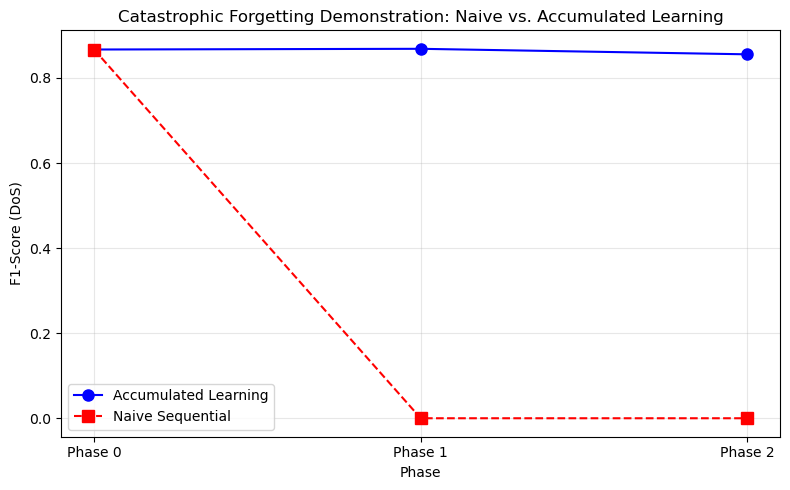

In [11]:
# Cell 7: So sánh trực quan Naive vs Accumulated — "Money Shot"
# X-axis: Phase 0, Phase 1, Phase 2 | Y-axis: F1-Score (lớp DoS)
# Accumulated = giữ F1 ổn định; Naive = F1 DoS/Normal sụt gần 0 khi chỉ train phase mới.

import matplotlib.pyplot as plt

CLASS_TO_PLOT = 'DoS'  # Có thể đổi thành 'Normal'
phases = ['Phase 0', 'Phase 1', 'Phase 2']

# Accumulated (Cell 5): Phase 0 -> report_0, Phase 1 -> report_01, Phase 2 -> report_012
f1_acc = [
    f1_cls(report_0, CLASS_TO_PLOT),
    f1_cls(report_01, CLASS_TO_PLOT),
    f1_cls(report_012, CLASS_TO_PLOT)
]
# Naive (Cell 6): Phase 0 -> report_0, Phase 1 -> report_naive_p1, Phase 2 -> report_naive_p2
f1_naive = [
    f1_cls(report_0, CLASS_TO_PLOT),
    f1_cls(report_naive_p1, CLASS_TO_PLOT),
    f1_cls(report_naive_p2, CLASS_TO_PLOT)
]

fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(phases))
ax.plot(x, f1_acc, 'b-o', label='Accumulated Learning', markersize=8)
ax.plot(x, f1_naive, 'r--s', label='Naive Sequential', markersize=8)
ax.set_xticks(x)
ax.set_xticklabels(phases)
ax.set_ylabel(f"F1-Score ({CLASS_TO_PLOT})")
ax.set_xlabel("Phase")
ax.set_title("Catastrophic Forgetting Demonstration: Naive vs. Accumulated Learning")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()